# House Prices - Advanced Regression Techniques
### Mitko Stoychev
*Titanic Top 5% with ensemble modeling* - *For this first version best model score is 0.0,79665*

07/04/2024

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
print(train_data.shape)
print(test_data.shape)
train_data.head(7)

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000


There are 81 columns, where 79 are feature columns.

Using these features, the model has to predict the house sale price indicated by the label column named "SalePrice".

I´ll drop the "Id" column because it´s not a feature column therefore it´s not necesarry for the model.

Let´s start inspecting the types of feature columns.

In [3]:
# Remove the "Id" columns
train_data = train_data.drop(["Id"], axis=1)
test_data = test_data.drop(["Id"], axis=1)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## House Price Distribution

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
median:  163000.0


C:\Users\Mitko Stoychev\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


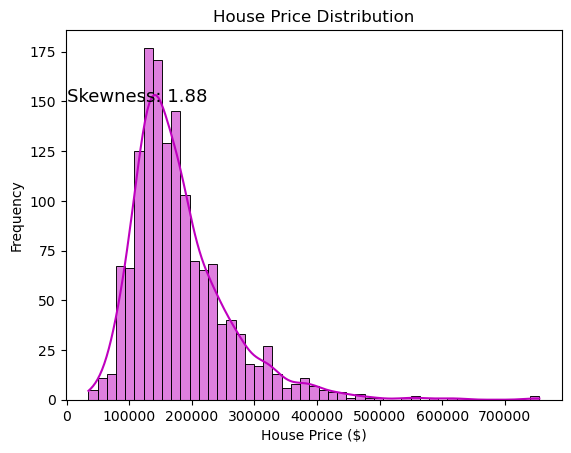

In [4]:
# Exploring SALE PRICE DISTRIBUTION

# Print SalePrice describe statistics
print(train_data['SalePrice'].describe())
print("median: ", train_data['SalePrice'].median())

# Plot a histrogram of SalePrice
sns.histplot(train_data["SalePrice"], color="m", kde=True)
plt.title("House Price Distribution")
plt.xlabel("House Price ($)")
plt.ylabel("Frequency")
plt.text(200, 150, "Skewness: %.2f" % train_data["SalePrice"].skew(), fontsize=13)
plt.show()

## Numerical data distribution
We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [5]:
train_data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [6]:
#select only the numeric data
df_num = train_data.select_dtypes(include=['int64', 'float64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let us plot the distribution for all the numerical features.

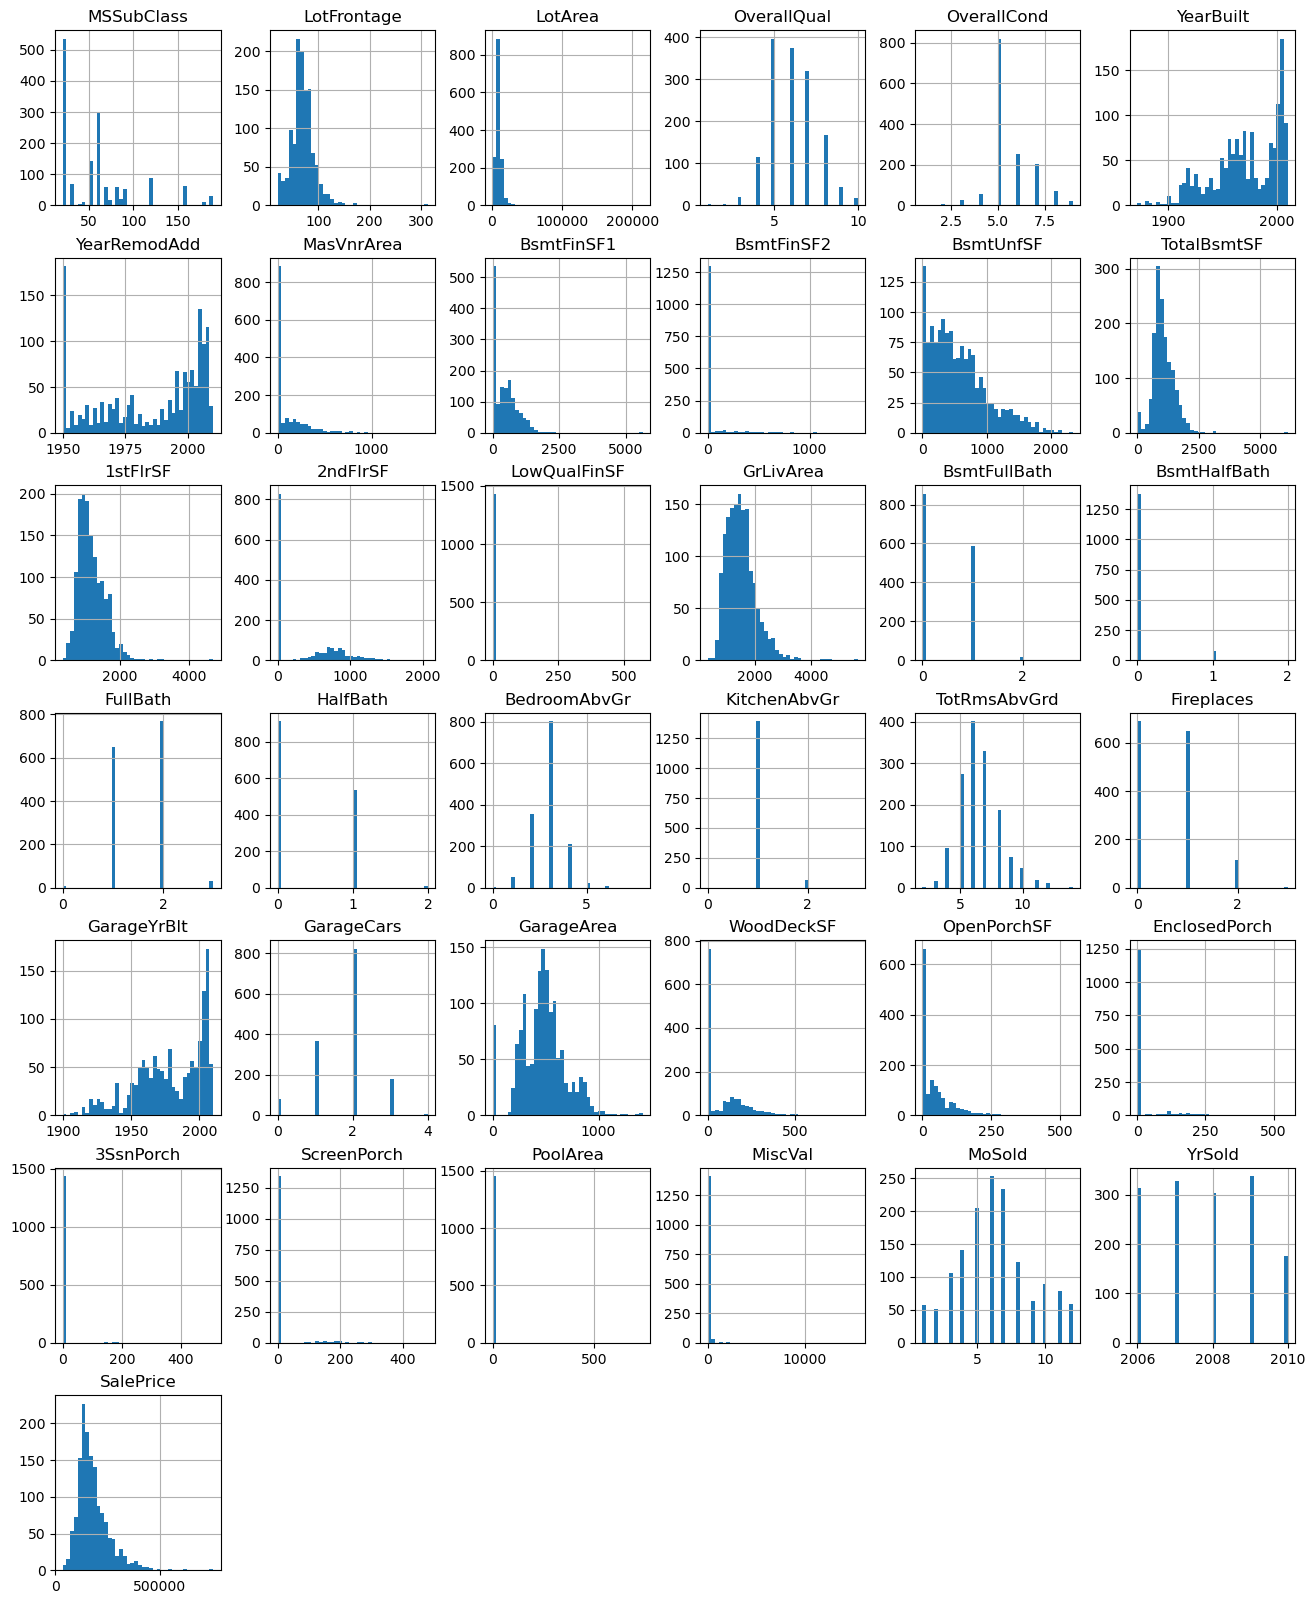

In [7]:
df_num.hist(figsize=(16,20), bins=40)
plt.show()

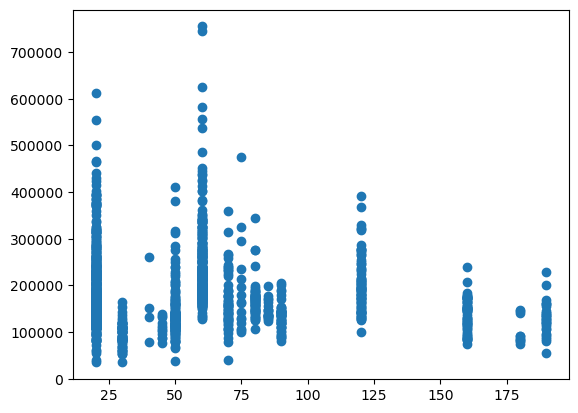

In [8]:
# MSSubClass → The building class → actually is a categorical data but already transformed
plt.scatter(x="MSSubClass", y="SalePrice", data=train_data)
plt.show()

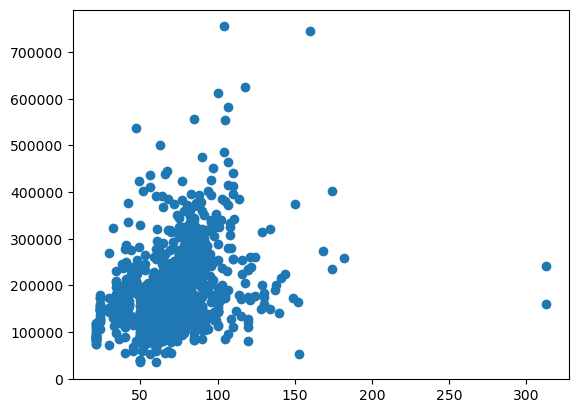

In [9]:
# LotFrontage → Linear feet of street connected to property 
plt.scatter(x="LotFrontage", y="SalePrice", data=train_data)
plt.show()

We can clearly see a 2 outliers. I am going to create a list with my outlier detection, then I´ll use the Tukeys method anyways.

In [10]:
train_data.query("LotFrontage > 300")
# Drop 934, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


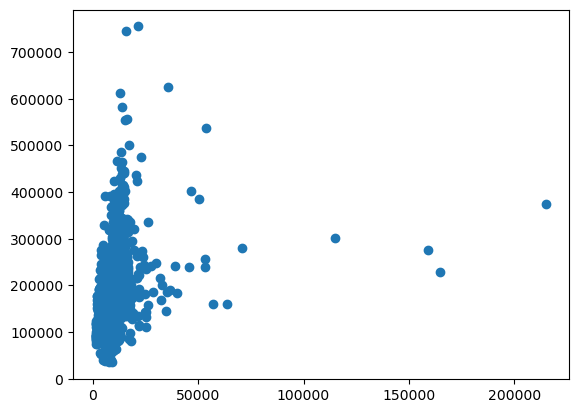

In [11]:
# LotArea → Lot size in square feet
plt.scatter(x="LotArea", y="SalePrice", data=train_data)
plt.show()

In [12]:
train_data.query("LotArea > 56000")

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000


In [13]:
# Drop 934, 1298, 249, 313, 335, 706
stats.zscore(train_data["LotArea"]).sort_values().tail(10)

384      4.268474
457      4.280500
769      4.308262
1396     4.678682
1298     5.348867
451      6.037793
706     10.486449
249     14.881285
335     15.448542
313     20.518273
Name: LotArea, dtype: float64

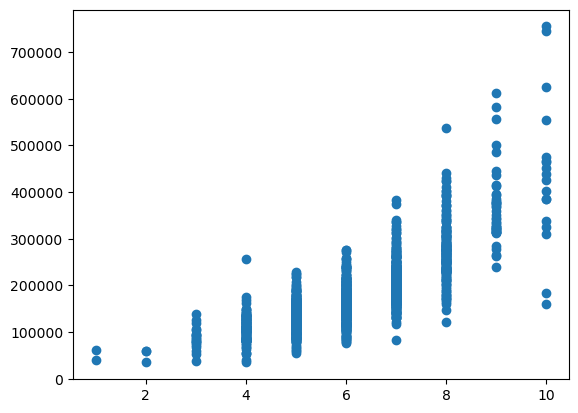

In [14]:
# OverallQual → Rates the overall material and finish of the house (ordinal data, aldeady encoded)
plt.scatter(x="OverallQual", y="SalePrice", data=train_data)
plt.show()

In [15]:
train_data.query("OverallQual == 10").sort_values("SalePrice")
# Drop →  249, 313, 335, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1442,60,FV,85.0,11003,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,310000
583,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
994,20,RL,96.0,12456,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,337500
825,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
224,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,386250
515,20,RL,94.0,12220,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2009,New,Partial,402861
389,60,RL,96.0,12474,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2008,New,Partial,426000
58,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780


In [16]:
train_data.query("OverallQual == 8").sort_values("SalePrice")
# Drop →  249, 313, 335, 523, 691, 706, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1349,70,RM,50.0,5250,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,122000
1324,20,RL,75.0,9986,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2007,New,Partial,147000
458,70,RM,NaN,5100,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,161000
1211,50,RL,152.0,12134,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,164000
991,70,RM,121.0,17671,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,168000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,20,RL,49.0,20896,Pave,NaN,IR2,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,1,2006,New,Partial,423000
1142,60,RL,77.0,9965,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2007,New,Partial,424870
496,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,430000
473,20,RL,110.0,14977,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2007,New,Partial,440000


In [17]:
train_data.query("OverallQual == 4").sort_values("SalePrice")
# Drop →  249, 313, 335, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
30,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,40000
1337,30,RM,153.0,4118,Pave,Grvl,IR1,Bnk,AllPub,Corner,...,0,NaN,NaN,NaN,0,3,2006,WD,Normal,52500
705,190,RM,70.0,5600,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,Othr,3500,7,2010,WD,Normal,55000
1325,30,RM,40.0,3636,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,1,2008,WD,Normal,55000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,20,RL,NaN,9991,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,GdWo,NaN,0,6,2009,WD,Normal,150000
1262,50,RL,NaN,11250,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,161500
1190,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1020,20,RL,60.0,7024,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,176000


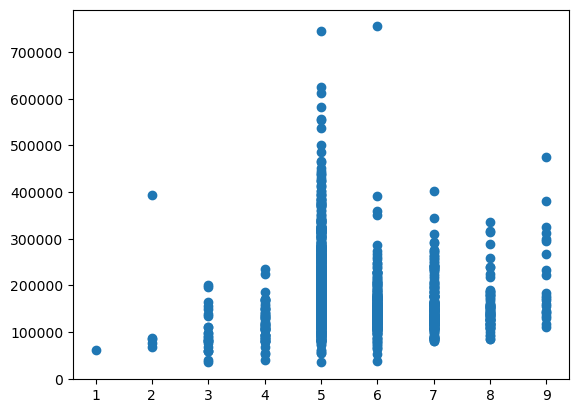

In [18]:
# OverallCond → Rates the overall condition of the house (ordinal data, aldeady encoded)
plt.scatter(x="OverallCond", y="SalePrice", data=train_data)
plt.show()

In [19]:
train_data.query("OverallCond == 2 & SalePrice > 300000")
# == 2 → 378
# == 5 → 1182
# == 6 → 691
# Drop →  249, 313, 335, 378, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
378,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432


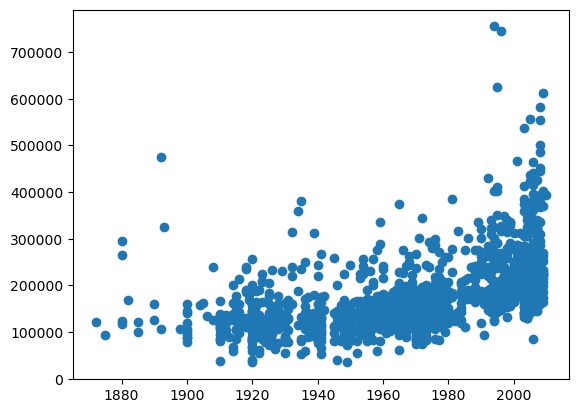

In [20]:
# YearBuilt → Original construction date
plt.scatter(x="YearBuilt", y="SalePrice", data=train_data)
plt.show()

In [21]:
train_data.query("YearBuilt < 1900 & SalePrice > 400000")
# Drop →  185, 249, 313, 335, 378, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


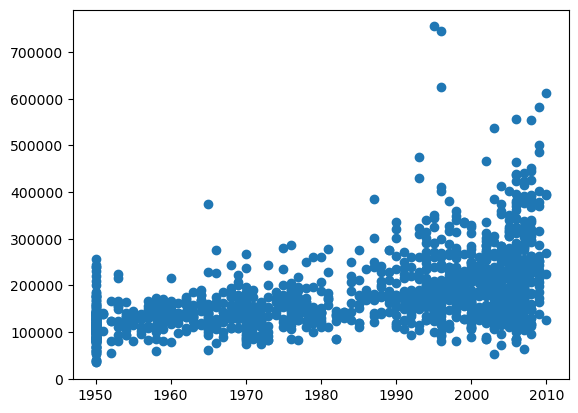

In [22]:
# YearRemodAdd → Remodel date (same as construction date if no remodeling or additions)
plt.scatter(x="YearRemodAdd", y="SalePrice", data=train_data)
plt.show()

In [23]:
train_data.query("YearRemodAdd < 1970 & SalePrice > 350000")
# Drop →  185, 249, 313, 335, 378, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


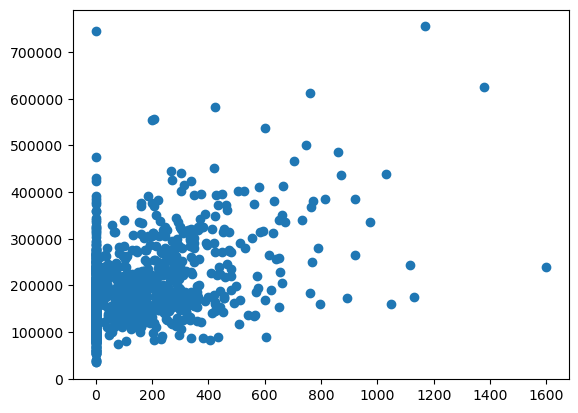

In [24]:
# MasVnrArea: Masonry veneer area in square feet
plt.scatter(x="MasVnrArea", y="SalePrice", data=train_data)
plt.show()

In [25]:
train_data.query("MasVnrArea > 1500")
# Drop →  185, 249, 297, 313, 335, 378, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


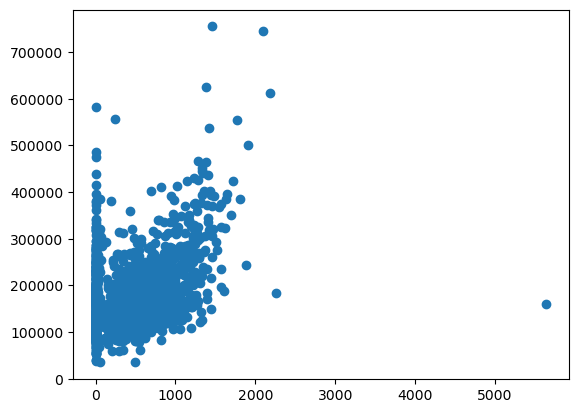

In [26]:
# BsmtFinSF1: Type 1 finished square feet
plt.scatter(x="BsmtFinSF1", y="SalePrice", data=train_data)
plt.show()

In [27]:
train_data.query("BsmtFinSF1 > 4000")
# Drop →  185, 249, 297, 313, 335, 378, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


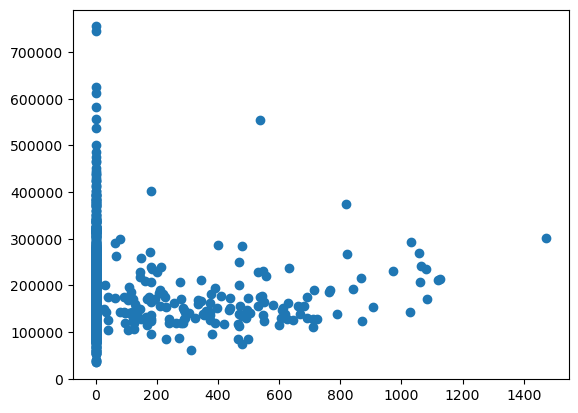

In [28]:
# BsmtFinSF2: Rating of basement finished area (if multiple types)
plt.scatter(x="BsmtFinSF2", y="SalePrice", data=train_data)
plt.show()

In [29]:
train_data.query("SalePrice > 500000 & BsmtFinSF2 >400")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
440,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


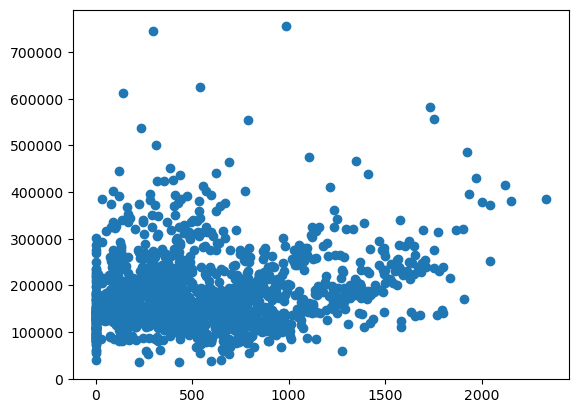

In [30]:
# BsmtUnfSF: Unfinished square feet of basement area
plt.scatter(x="BsmtUnfSF", y="SalePrice", data=train_data)
plt.show()

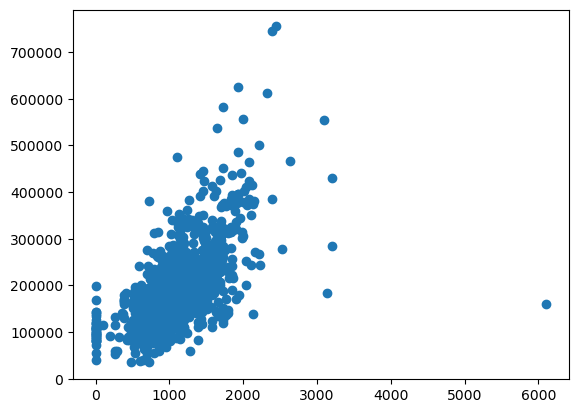

In [31]:
# TotalBsmtSF: Total square feet of basement area
plt.scatter(x="TotalBsmtSF", y="SalePrice", data=train_data)
plt.show()

In [32]:
train_data.query("TotalBsmtSF > 6000")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


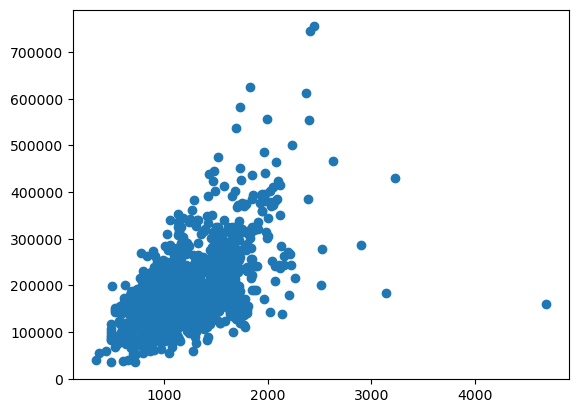

In [33]:
# 1stFlrSF: First Floor square feet
plt.scatter(x="1stFlrSF", y="SalePrice", data=train_data)
plt.show()

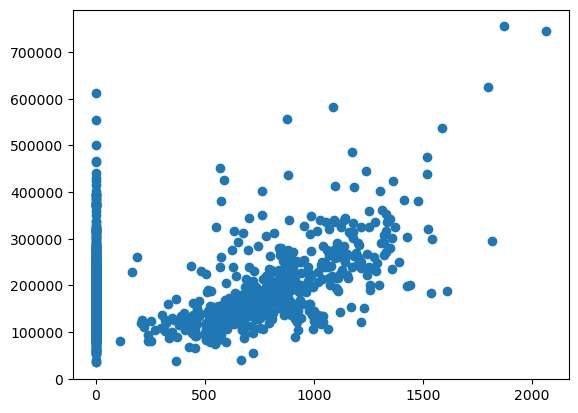

In [34]:
# 2ndFlrSF: Second Floor square feet
plt.scatter(x="2ndFlrSF", y="SalePrice", data=train_data)
plt.show()

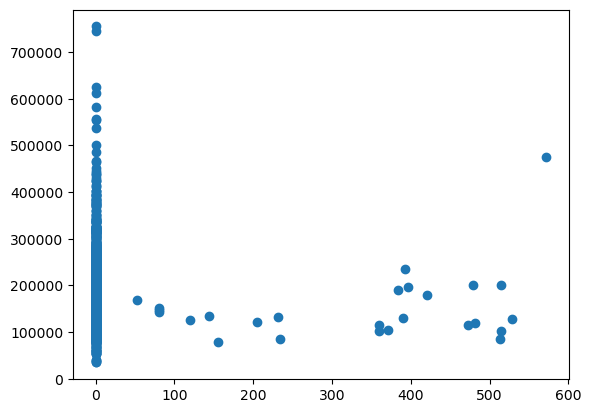

In [35]:
# LowQualFinSF: Low quality finished square feet (all floors)
plt.scatter(x="LowQualFinSF", y="SalePrice", data=train_data)
plt.show()

In [36]:
train_data.query("LowQualFinSF > 550")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


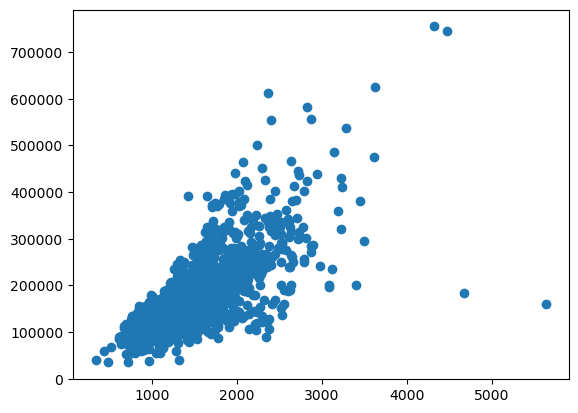

In [37]:
# GrLivArea: Above grade (ground) living area square feet
plt.scatter(x="GrLivArea", y="SalePrice", data=train_data)
plt.show()

In [38]:
train_data.query("GrLivArea > 4500")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 691, 706, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


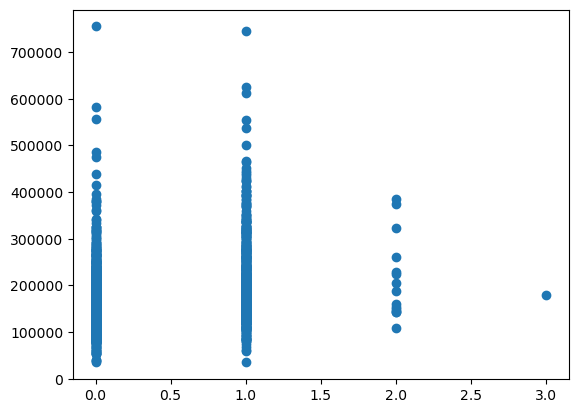

In [39]:
# BsmtFullBath:  Basement full bathrooms
plt.scatter(x="BsmtFullBath", y="SalePrice", data=train_data)
plt.show()

In [40]:
train_data.query("BsmtFullBath == 3")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 691, 706, 738, 769, 934, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
738,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000


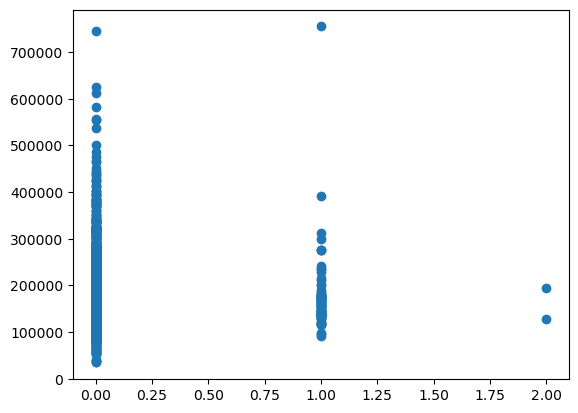

In [41]:
# BsmtHalfBath:  Basement half bathrooms
plt.scatter(x="BsmtHalfBath", y="SalePrice", data=train_data)
plt.show()

In [42]:
train_data.query("BsmtHalfBath == 2")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 597, 691, 706, 738, 769, 934, 954, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
597,120,RL,53.0,3922,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2007,New,Partial,194201
954,90,RL,35.0,9400,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,10,2006,WD,AdjLand,127500


In [43]:
stats.zscore(train_data["BsmtHalfBath"]).unique()

array([-0.24106104,  3.94880935,  8.13867973])

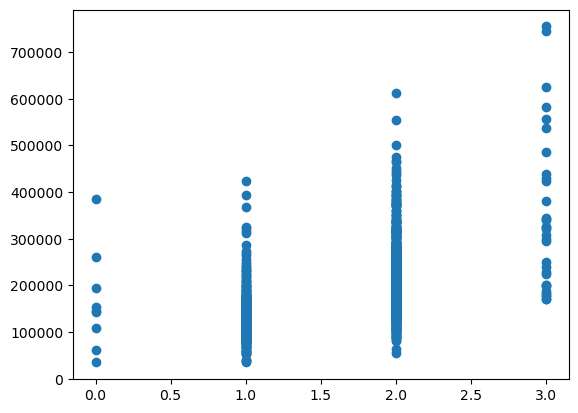

In [44]:
# FullBath: Full bathrooms above grade
plt.scatter(x="FullBath", y="SalePrice", data=train_data)
plt.show()

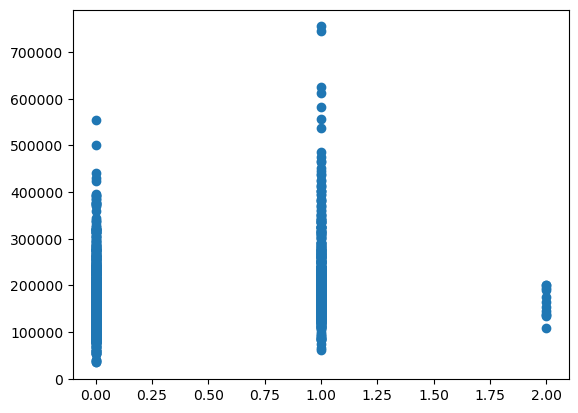

In [45]:
# HalfBath: Half baths above grade
plt.scatter(x="HalfBath", y="SalePrice", data=train_data)
plt.show()

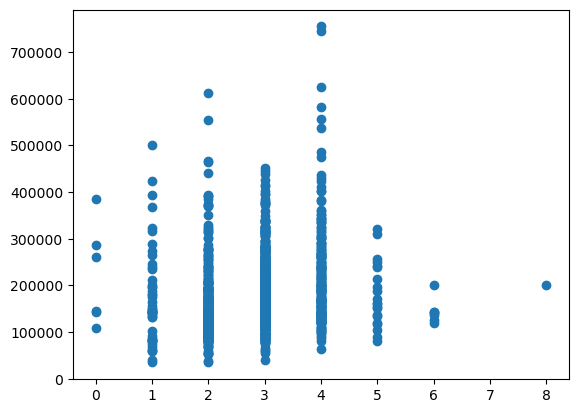

In [46]:
# BedroomAbvGr → Bedrooms above ground
plt.scatter(x="BedroomAbvGr", y="SalePrice", data=train_data)
plt.show()

In [47]:
train_data.query("BedroomAbvGr == 8")
# Drop →  185, 249, 297, 313, 335, 378, 440, 457, 523, 597, 635, 691, 706, 738, 769, 934, 954, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


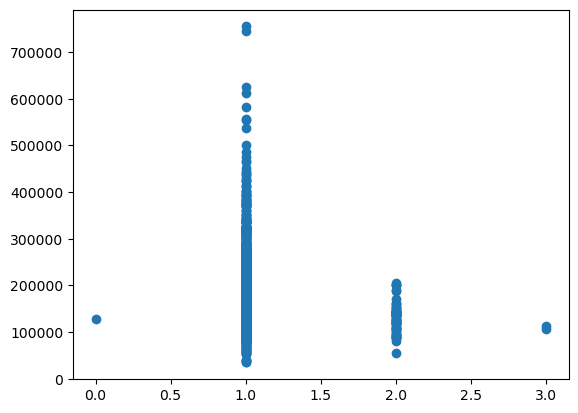

In [48]:
# KitchenAbvGr → Kitchen above ground
plt.scatter(x="KitchenAbvGr", y="SalePrice", data=train_data)
plt.show()

In [49]:
train_data.query("KitchenAbvGr == 3")
# Drop → 48, 185, 249, 297, 313, 335, 378, 440, 457, 523, 597, 635, 691, 706, 738, 769, 809, 934, 954, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
809,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000


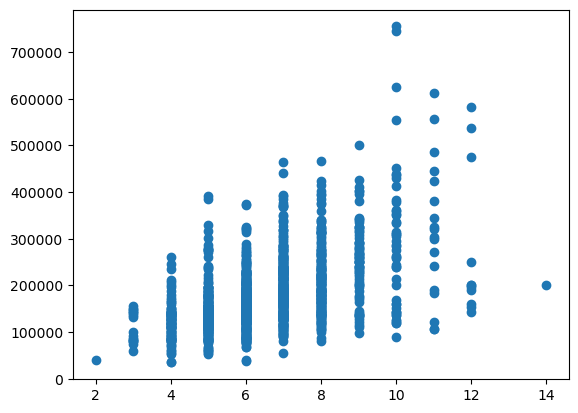

In [50]:
# TotRmsAbvGrd → Total rooms above ground
plt.scatter(x="TotRmsAbvGrd", y="SalePrice", data=train_data)
plt.show()

In [51]:
train_data.query("TotRmsAbvGrd == 14")
# Drop → 48, 185, 249, 297, 313, 335, 378, 440, 457, 523, 597, 635, 691, 706, 738, 769, 809, 934, 954, 1182, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


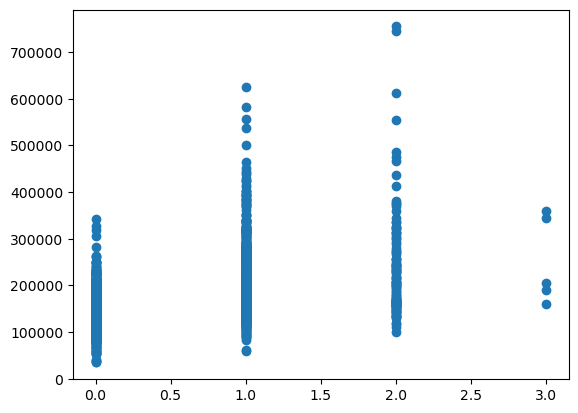

In [52]:
# Fireplaces → Number of fireplaces
plt.scatter(x="Fireplaces", y="SalePrice", data=train_data)
plt.show()

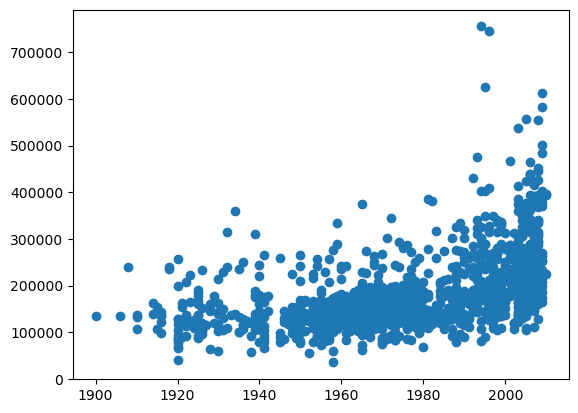

In [53]:
# GarageYrBlt → Garage year built
plt.scatter(x="GarageYrBlt", y="SalePrice", data=train_data)
plt.show()

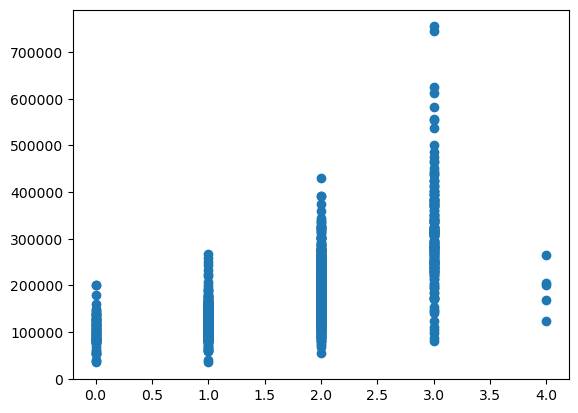

In [54]:
# GarageCars → Garage cars
plt.scatter(x="GarageCars", y="SalePrice", data=train_data)
plt.show()

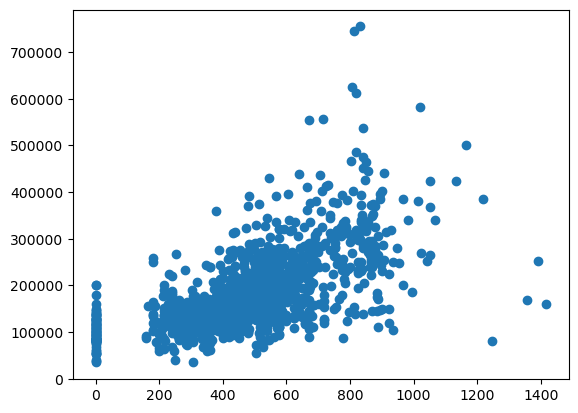

In [55]:
# GarageArea → Garage area
plt.scatter(x="GarageArea", y="SalePrice", data=train_data)
plt.show()

In [56]:
train_data.query("GarageArea > 1200")
# Drop → 48, 185, 249, 297, 313, 335, 378, 440, 457, 523, 581, 597, 635, 691, 706, 738, 769, 809, 825, 934, 954, 1061, 1182, 1190, 1298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
825,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
1061,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


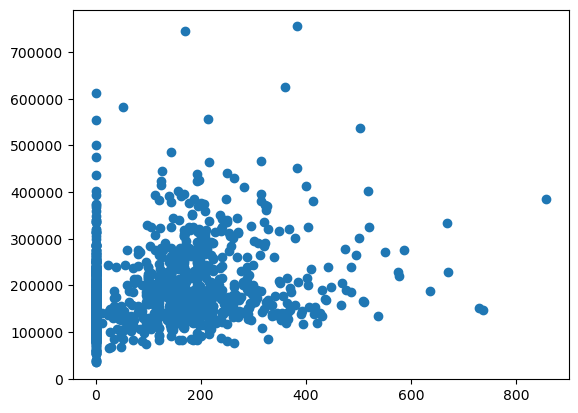

In [57]:
# WoodDeckSF → Wood deck area in square feet
plt.scatter(x="WoodDeckSF", y="SalePrice", data=train_data)
plt.show()

In [58]:
train_data.query("WoodDeckSF > 675")
# Drop → 48, 53, 185, 249, 297, 313, 335, 378, 440, 457, 523, 581, 597, 635, 691, 706, 738, 769, 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
53,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000
1068,160,RM,42.0,3964,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,151400
1459,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


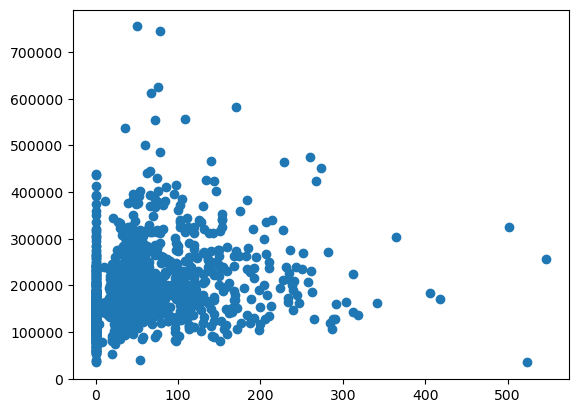

In [59]:
# OpenPorchSF → Open porch area in square feet
plt.scatter(x="OpenPorchSF", y="SalePrice", data=train_data)
plt.show()

In [60]:
train_data.query("OpenPorchSF > 475")
# Drop → 48, 53, 185, 249, 297, 313, 335, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
# 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
583,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
1328,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,Shed,1150,6,2008,WD,Normal,256000


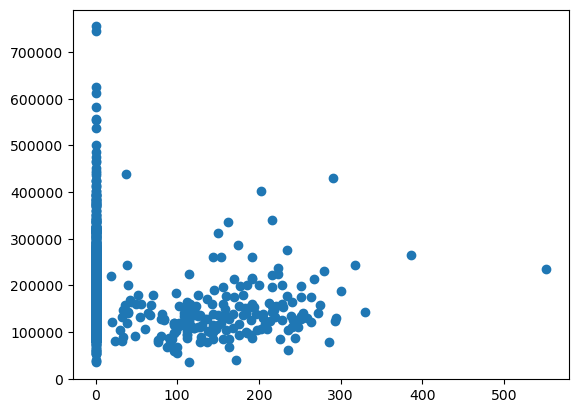

In [61]:
# EnclosedPorch → Enclosed porch area in square feet
plt.scatter(x="EnclosedPorch", y="SalePrice", data=train_data)
plt.show()

In [62]:
train_data.query("EnclosedPorch > 500")
# Drop → 48, 53, 185, 197, 249, 297, 313, 335, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
# 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000


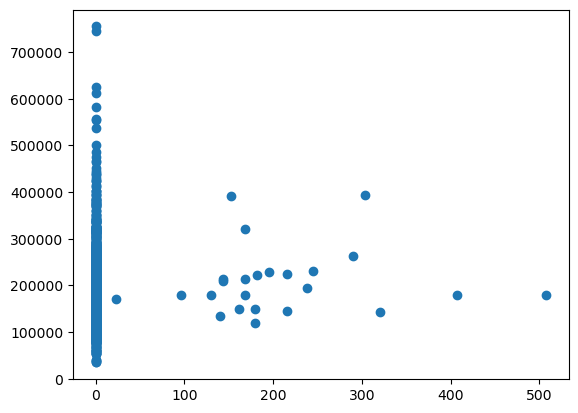

In [63]:
# 3SsnPorch → Three season porch area in square feet
plt.scatter(x="3SsnPorch", y="SalePrice", data=train_data)
plt.show()

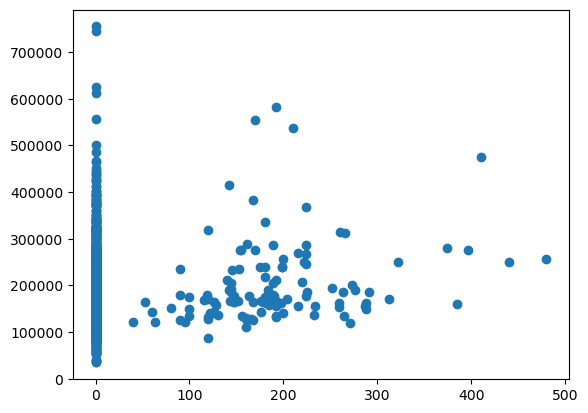

In [64]:
# ScreenPorch → Screen porch area in square feet
plt.scatter(x="ScreenPorch", y="SalePrice", data=train_data)
plt.show()

In [65]:
train_data.query("ScreenPorch > 400")
# Drop → 48, 53, 185, 197, 249, 297, 313, 335, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
# 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1386, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
1328,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,Shed,1150,6,2008,WD,Normal,256000
1386,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,...,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal,250000


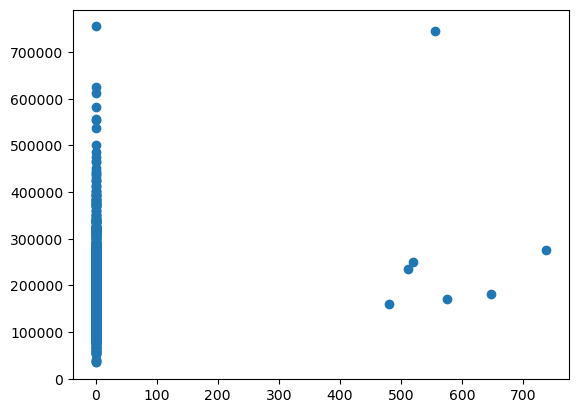

In [66]:
# PoolArea → Pool area in square feet
plt.scatter(x="PoolArea", y="SalePrice", data=train_data)
plt.show()

In [67]:
train_data.query("PoolArea > 700")
# Drop → 48, 53, 185, 197, 249, 297, 313, 335, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
# 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1386, 1423, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1423,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970


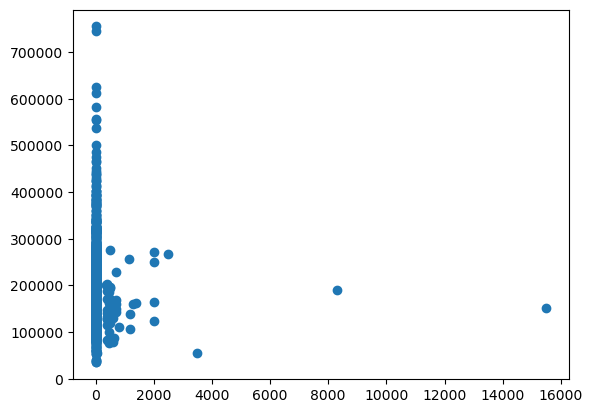

In [68]:
# MiscVal → $Value of miscellaneous feature
plt.scatter(x="MiscVal", y="SalePrice", data=train_data)
plt.show()

In [69]:
train_data.query("MiscVal > 8000")
# Drop → 48, 53, 185, 197, 249, 297, 313, 335, 346, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
# 809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1230 1386, 1423, 1459

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
346,20,RL,NaN,12772,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,Gar2,15500,4,2007,WD,Normal,151500
1230,90,RL,NaN,18890,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,Gar2,8300,8,2007,WD,Normal,190000


In [70]:
values_indx = [48, 53, 185, 197, 249, 297, 313, 335, 346, 378, 440, 457, 495, 523, 581, 583, 597, 635, 691, 706, 738, 769, 
               809, 825, 934, 954, 1061, 1068, 1182, 1190, 1298, 1328, 1230, 1386, 1423, 1459]

Finally I have found the alleged outliers. 

I am going to proceed to delete them from the dataset.

In [71]:
# DROP THE OUTLIERS
train_data = train_data.drop(values_indx)